# Regression

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/philmui/study-algorithmic-bias/blob/main/notebooks/03_regression.ipynb"><img src="../images/asdrp-logo.png" width=50px />Run in Google Colab</a>
  </td>
</table>

# Setup

Loading libraries & check for compatibilities

In [1]:
!pip install -q seaborn

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
2.2.0


In [2]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    import matplotlib.pyplot as plt

# UCI Machine Learning MPG Dataset

The dataset is available from [UCI Machine Learning Repo](https://archive.ics.uci.edu/ml/)

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [4]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Data Cleaning

Entries with '?' represents unknown values.  Let's see how many there are.

In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Decision: let's drop these rows

In [6]:
dataset = dataset.dropna()

The 'Origin' column is not numeric but should be categorical

In [7]:
dataset.dtypes

MPG             float64
Cylinders         int64
Displacement    float64
Horsepower      float64
Weight          float64
Acceleration    float64
Model Year        int64
Origin            int64
dtype: object

A common way to handle categorical variable is to perform "one-hot" encoding.

In [8]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})


In [9]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,USA
1,15.0,8,350.0,165.0,3693.0,11.5,70,USA
2,18.0,8,318.0,150.0,3436.0,11.0,70,USA
3,16.0,8,304.0,150.0,3433.0,12.0,70,USA
4,17.0,8,302.0,140.0,3449.0,10.5,70,USA


In [10]:
dataset['Origin'].value_counts()

USA       245
Japan      79
Europe     68
Name: Origin, dtype: int64

In [11]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [12]:
print(f"Europe: {dataset.Europe.sum()}, Japan: {dataset.Japan.sum()}, USA: {dataset.USA.sum()}")

Europe: 68, Japan: 79, USA: 245


# Preparing for Training

In [13]:
dataset.shape

(392, 10)

Let's split the dataset into train and test sets

In [14]:
train_ratio = 0.8
test_ratio  = 1-train_ratio

train_set = dataset.sample(frac=train_ratio, random_state=0)
test_set = dataset.drop(train_set.index)

print(f"train_set: {train_set.shape}, test_set: {test_set.shape}")

train_set: (314, 10), test_set: (78, 10)


### Visualize the training set

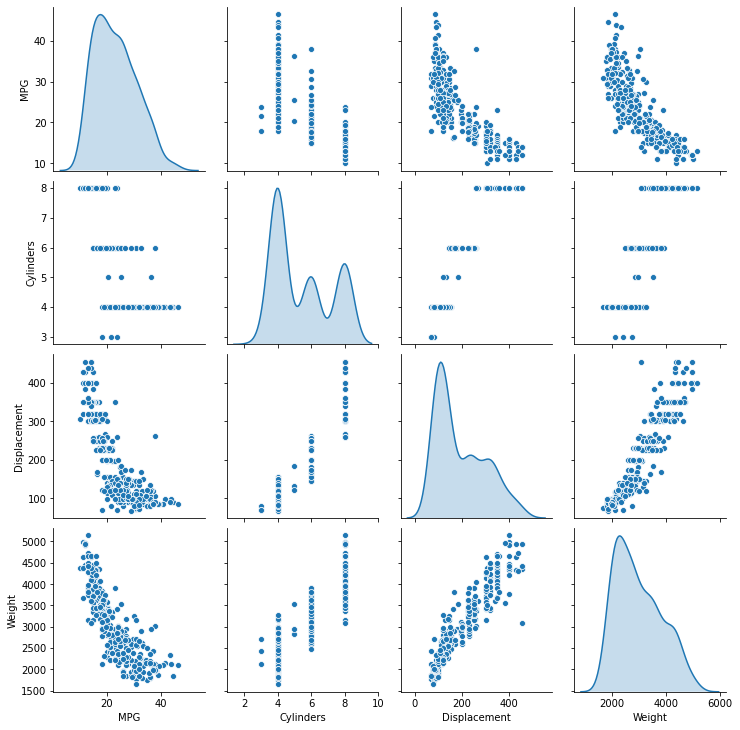

In [15]:
sns.pairplot(train_set[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

The diagonal plots are: kernel density estimate (KDE) plots.  KDE is a method for visualizing the distribution of observations in a dataset, analagous to a histogram. KDE represents the data using a continuous probability density curve in one or more dimensions.

Looking at the top row it should be clear that the fuel efficiency (MPG) is a function of all the other parameters. Looking at the other rows it should be clear that they are functions of each other.

### Split features from labels

Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [16]:
train_X = train_set.copy()
test_X = test_set.copy()

train_y = train_X.pop('MPG')
test_y = test_X.pop('MPG')

In [17]:
print(f"train_X: {train_X.shape}, train_y: {train_y.shape}")

train_X: (314, 9), train_y: (314,)


### Normalize data

In [18]:
train_set.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

There are a number of libraries that we can use to normalize the data across features.  We will try one provided by [Kera's preprocessing library](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing).

The preprocessing.Normalization layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [61]:
normalizer = preprocessing.Normalization()

Then adapt this to the data

In [62]:
normalizer.adapt(np.array(train_X))

This calculates the mean and variance, and stores them in the layer.m

In [63]:
print(normalizer.mean.numpy())

[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]


When the layer is called it returns the input data, with each feature independently normalized:


In [22]:
first = np.array(train_X[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print('Normalized:', normalizer(first).numpy())


First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]
Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Linear Regression DNN

### One Variable
Start with a single-variable linear regression, to predict MPG from Horsepower.

Training a model with `tf.keras` typically starts by defining the model architecture.

In this case use a `keras.Sequential` model. This model represents a sequence of steps. In this case there are two steps:

- Normalize the input horsepower.
- Apply a linear transformation (`y=mx+b`) to produce 1 output using `layers.Dense`.

The number of inputs can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First create the horsepower Normalization layer:

In [23]:
horsepower = np.array(train_X[['Horsepower']])
horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
#horsepower = np.array(train_X[['Displacement', 'Horsepower']])
#horsepower_normalizer = preprocessing.Normalization()

horsepower_normalizer.adapt(horsepower)

In [24]:
horsepower_normalizer.mean.numpy()

array([104.869], dtype=float32)

Build the sequential model:

In [25]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model can now predict MPG from Horsepower.

Run the untrained model on the first 10 horse-power values. The output won't be good, but you'll see that it has the expected shape, (10,1):

In [26]:
horsepower_model.predict(horsepower[:10])

array([[ 0.812],
       [ 0.458],
       [-1.498],
       [ 1.138],
       [ 1.029],
       [ 0.404],
       [ 1.219],
       [ 1.029],
       [ 0.268],
       [ 0.458]], dtype=float32)

Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`).

In [27]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [30]:
%%time
history = horsepower_model.fit(
    train_X[['Horsepower']], train_y,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 2.78 s, sys: 259 ms, total: 3.04 s
Wall time: 2.57 s


Visualize the model's training progress using the stats stored in the history object.

In [34]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,val_loss,epoch
0,22.879583,22.933130,0
1,22.067324,22.132763,1
2,21.261770,21.332783,2
3,20.463587,20.532919,3
4,19.663948,19.732803,4


In [32]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

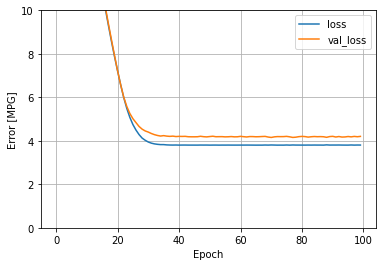

In [33]:
plot_loss(history)

In [37]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_X[['Horsepower']],
    test_y, verbose=0)

Since this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [38]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [39]:
def plot_horsepower(x, y):
  plt.scatter(train_X[['Horsepower']], train_y, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

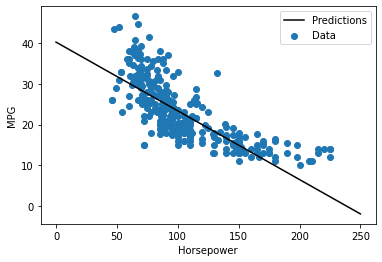

In [40]:
plot_horsepower(x,y)

### Multiple Variable

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time use the `Normalization` layer that was adapted to the whole dataset.

In [42]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call this model on a batch of inputs, it produces units=1 outputs for each example.

In [43]:
linear_model.predict(train_X[:10])

array([[-0.278],
       [ 0.879],
       [ 2.354],
       [-0.189],
       [-2.605],
       [ 1.535],
       [-2.645],
       [-0.146],
       [ 1.221],
       [-2.387]], dtype=float32)

When you call the model it's weight matrices will be built. Now you can see that the `kernel` (the $m$ in $y=mx+b$) has a shape of `(9,1)`.

In [44]:
linear_model.layers[1].kernel

<tf.Variable 'sequential_2/dense_2/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.063],
       [ 0.38 ],
       [-0.107],
       [ 0.691],
       [ 0.399],
       [-0.013],
       [-0.223],
       [-0.562],
       [ 0.707]], dtype=float32)>

Use the same `compile` and `fit` calls as for the 

---

single input `horsepower` model:

In [45]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [47]:
%%time
history = linear_model.fit(
    train_X, train_y, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 2.88 s, sys: 227 ms, total: 3.1 s
Wall time: 2.77 s


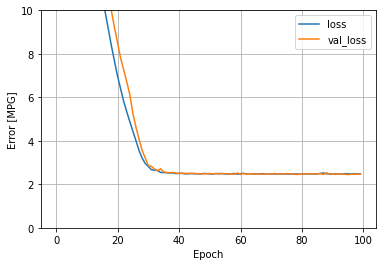

In [48]:
plot_loss(history)

Collect the results on the test set, for later:


In [50]:
test_results['linear_model'] = linear_model.evaluate(
    test_X, test_y, verbose=0)

# Multi-Layer Perceptron (MLP)

So far, we have implemented linear models for single and multiple inputs.

We will now include some "hidden"  non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

Both will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [51]:
def build_and_compile_model(normalizer_layer):
  model = keras.Sequential([
      normalizer_layer,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### 1 Variable MLP

In [52]:
mlp_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [53]:
mlp_horsepower_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


With the significantly larger # parameters, the training should take longer:

In [54]:
%%time
history = mlp_horsepower_model.fit(
    train_X[['Horsepower']], train_y,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.16 s, sys: 674 ms, total: 3.83 s
Wall time: 2.93 s


This new model should perform better than the linear-(no hidden layer)-horsepower model, right?

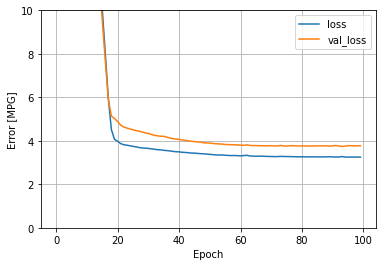

In [55]:
plot_loss(history)

If you plot the predictions as a function of Horsepower, you'll see how this model takes advantage of the nonlinearity provided by the hidden layers:

In [57]:
x = tf.linspace(0.0, 250, 251)
y = mlp_horsepower_model.predict(x)

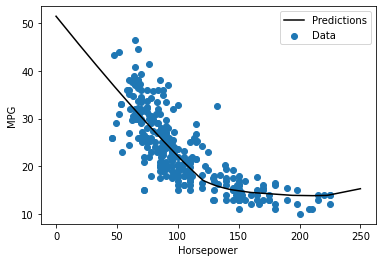

In [58]:
plot_horsepower(x, y)

Collect the results on the test set, for later:

In [59]:
test_results['mlp_horsepower_model'] = mlp_horsepower_model.evaluate(
    test_X[['Horsepower']], test_y,
    verbose=0)

### Multiple variable MLP

In [65]:
dnn_model = build_and_compile_model(normalizer)

In [66]:
%%time
history = dnn_model.fit(
    train_X, train_y,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.34 s, sys: 772 ms, total: 4.12 s
Wall time: 2.97 s


In [67]:
dnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati multiple                  19        
_________________________________________________________________
dense_12 (Dense)             multiple                  640       
_________________________________________________________________
dense_13 (Dense)             multiple                  4160      
_________________________________________________________________
dense_14 (Dense)             multiple                  65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [68]:
test_results['dnn_model'] = dnn_model.evaluate(test_X, test_y, verbose=0)

### Performance Comparison

Now that all the models are trained check the test-set performance and see how they did:

In [69]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.649532
linear_model,2.523153
mlp_horsepower_model,2.914777
dnn_model,1.679632


### Making Predictions

Finally, predict have a look at the errors made by the model when making predictions on the test set:

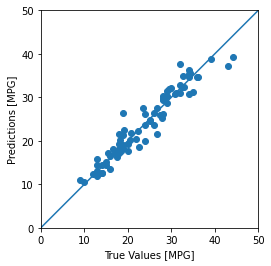

In [72]:
test_predictions = dnn_model.predict(test_X).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_y, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


Pretty good right?

Let's look at the error distribution:

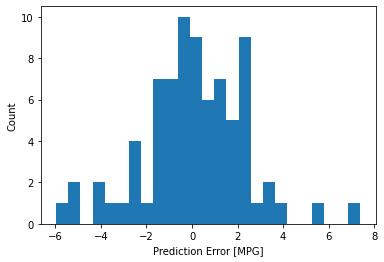

In [73]:
error = test_predictions - test_y
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

Let's now save the model:

In [74]:
dnn_model.save('dnn_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: dnn_model/assets


*If* you reload the model, it gives identical output:

In [76]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_X, test_y, verbose=0)

In [77]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.649532
linear_model,2.523153
mlp_horsepower_model,2.914777
dnn_model,1.679632
reloaded,1.679632


## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

* [Mean Squared Error (MSE)](https://www.tensorflow.org/api_docs/python/tf/losses/MeanSquaredError) and [Mean Absolute Error (MAE)](https://www.tensorflow.org/api_docs/python/tf/losses/MeanAbsoluteError) are common loss functions used for regression problems. Mean Absolute Error is less sensitive to outliers. Different loss functions are used for classification problems.
* Similarly, evaluation metrics used for regression differ from classification.
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* Overfitting is a common problem for DNN models, it wasn't a problem for this tutorial. See the [overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.
